# AB Testing example on Cookie Cats Mobile Game
In this python notebook, we will perform AB testing for a mobile game feature that involves changing the gameplay a little by changing the level upgrade at gate 30(control) vs gate(40). In the dataset, the users are either classified as control or treatment groups. Also, D1 and D7 retention flags are given along with session counts. Both frequentist and bayesian methods are applied to reach to the final conclusion. 

## Import Libraries

In [ ]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/My Drive/Cookie cats/'
drive = '/content/drive/My Drive/Cookie cats/'

archive.zip  cookie_cats.csv


## Load Dataset

In [ ]:
data = pd.read_csv(drive + 'cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
print(data.info())
print(data['version'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None
gate_40    45489
gate_30    44700
Name: version, dtype: int64


## Data Preprocessing

In [ ]:
data['is_valid'] = data['sum_gamerounds'].apply(lambda x: True if (x < 250) and (x >= 0) else False)
data = data.loc[data['is_valid']]
gate_30 = data[data['version']=='gate_30']  #control
gate_40 = data[data['version']=='gate_40']  #Treatment
print(gate_30.head())
print(gate_40.head())

    userid  version  sum_gamerounds  retention_1  retention_7  is_valid
0      116  gate_30               3        False        False      True
1      337  gate_30              38         True        False      True
6     1066  gate_30               0        False        False      True
11    2101  gate_30               0        False        False      True
13    2179  gate_30              39         True        False      True
   userid  version  sum_gamerounds  retention_1  retention_7  is_valid
2     377  gate_40             165         True        False      True
3     483  gate_40               1        False        False      True
4     488  gate_40             179         True         True      True
5     540  gate_40             187         True         True      True
7    1444  gate_40               2        False        False      True


## T test to check if games distribution for control and test groups are different

In [ ]:
from scipy.stats import ttest_ind
order_value_control_group = gate_30['sum_gamerounds'].to_list()
order_value_experimental_group = gate_40['sum_gamerounds'].to_list()
zscore, prob= ttest_ind(order_value_control_group, order_value_experimental_group, equal_var=False)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -0.19, p-value is 0.849 (two tailed), 0.424 (one tailed)


Since the p-value is greater than 0.05 we fail to reject the null hypothesis and the two distributions of gate 30 and gate 40 seem to be coming from the same game distibution. This indicates there is no bias in the data between the control and treatment group. All the users are well distributed.


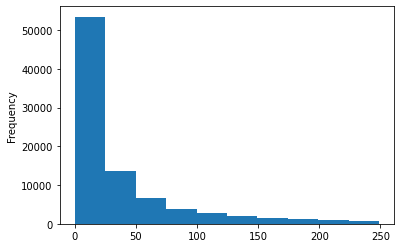

In [ ]:
data['sum_gamerounds'].plot.hist()

### Null Hypothesis and Alternate Hypothesis


What are the questions for which we want answers?

1. Did the 1-Day Retention rate increase after moving the gate to level 40? Null: gate 40 is not better than gate 30 using D1 retention metric Alternate: gate 40 is better than gate 30 using D1 retention metric
2. Did the 7-Day Retention rate increase after moving the gate to level 40? Null: gate 40 is not better than gate 30 using D7 retention metric Alternate: gate 40 is better than gate 30 using D7 retention metric

## Day 1 Retention

In [ ]:
import statsmodels.stats.api as sms
import scipy.stats as st

total_users_control = gate_30['retention_1'].size
total_users_treatment = gate_40['retention_1'].size
total_users = total_users_control + total_users_treatment

print("Split of control users who saw old gate vs treatment users who saw new gate: ", 
          round(total_users_control/ total_users * 100, 2), "% ",
          round(total_users_treatment / total_users * 100, 2), "%")

#count number of users who retained in each group
conversions_control = gate_30['retention_1'].value_counts().loc[True]
print("Number of control users who retained on old gate: ", conversions_control)
print("Percentage of control users who retained: ", round((conversions_control / total_users_control) * 100, 6), "%")

conversions_treatment = gate_40['retention_1'].value_counts().loc[True]
print("Number of treatment users who retained on new gate: ", conversions_treatment)
print("Percentage of treatment users who retained: ", round((conversions_treatment/ total_users_treatment) * 100, 6), "%")

Split of control users who saw old gate vs treatment users who saw new gate:  49.54 %  50.46 %
Number of control users who retained on old gate:  18272
Percentage of control users who retained:  42.658698 %
Number of treatment users who retained on new gate:  18370
Percentage of treatment users who retained:  42.101162 %


The change seems to have reduced the number of retentions 42.65 % vs  42.10 %. In order to check if the retentions are due to chance, we will conduct statistical tests.

In [ ]:
baseline_rate = conversions_control / total_users_control
practical_significance = 0.01 #user defined
confidence_level = 0.05 #user defined, for a 95% confidence interval
sensitivity = 0.8 #user defined

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group for Day 1 Retention")

Required sample size:  38508  per group for Day 1 Retention


In [ ]:
print(' Total Users in Control Group :', total_users_control)
print(' Total Users in Treatment Group :', total_users_treatment)

 Total Users in Control Group : 42833
 Total Users in Treatment Group : 43633


Retention-1 Day Baseline Retention-1 Day: 42.65% Minimum Detectable Effect: 0.01 alpha: 5% beta: 20% 1-beta: 80% Number of groups = 2 (control and Treatment) sample size = 38508 Treatment/group total sample size = 38508x2 



## AB Testing (Z Test - Frequentist) for D1 Retention

In [ ]:
prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)

In [ ]:
import math

se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / total_users_control + 1 / total_users_treatment))
z_score = st.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score

#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_treatment / total_users_treatment) - (conversions_control / total_users_control)

#Test if we can reject the null hypothesis
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

if practical_significance < lower_bound:
    print("Reject null hypothesis. Gate 40 may be better than gate 30, as per the agreed confidence level of 5%")
else: 
    print("Do not reject the null hypothesis. Gate 40 may not be any better than gate 30.")
    
print("The lower bound of the confidence interval is ", round(lower_bound * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound * 100, 2), "%")

Do not reject the null hypothesis. Gate 40 may not be any better than gate 30.
The lower bound of the confidence interval is  -1.22 %
The upper bound of the confidence interval is  0.1 %


The new gate (gate 40) may not be a good update to the existing gate 30 given the significance level.

 ## Bland-Altman Plot for D7 Retention

In [ ]:
import numpy as np

db = data[['version', 'retention_1', 'retention_7']]
nbr_sample = 300
length_sample = []
for i in range(nbr_sample):
	value = np.random.RandomState(893717398+i).randint(200, 1000)
	length_sample.append(value)

length_sample = list(np.repeat(length_sample, 50))

db_bootstrapped = pd.DataFrame()
for i in range(len(length_sample)):
    tmp = db.sample(n=length_sample[i], random_state=893717398+i, replace=True)
    tmp['n_sample'] = i
    tmp['n_sample_2'] = length_sample[i]
    tmp = pd.DataFrame(tmp)
    db_bootstrapped = db_bootstrapped.append(tmp)
    del(tmp)

In [ ]:
db = db_bootstrapped.groupby(['n_sample','n_sample_2','version'])['retention_7'].sum()
db=db.groupby(['n_sample_2','version']).mean()

In [ ]:
db.head()

n_sample_2  version
200         gate_30    15.24
            gate_40    16.08
202         gate_30    16.72
            gate_40    14.92
205         gate_30    16.98
Name: retention_7, dtype: float64

In [ ]:
db = db.unstack()

In [ ]:
db['x'] = ((db['gate_30'] + db['gate_40'])/2)
db['y'] = ((db['gate_30'] - db['gate_40'])*100)/((db['gate_30'] + db['gate_40'])/2)

We need to check for the normality of the y metric as per the Bland Altman procedure.

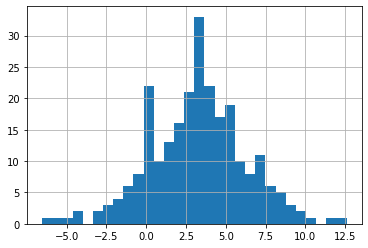

In [ ]:
db['y'].hist(bins=30)

In [ ]:
print('Mean of y: '+ str(db['y'].mean()))
print('Upper-bound at 95%: ' + str(db['y'].mean() + 1.96*db['y'].std()))
print('Lower-bound at 95%: ' + str(db['y'].mean() - 1.96*db['y'].std()))

Mean of y: 3.2290455494583297
Upper-bound at 95%: 9.14131276654861
Lower-bound at 95%: -2.683221667631951


## Importing Libraries

In [ ]:
!pip install pycompare

import pyCompare as pc

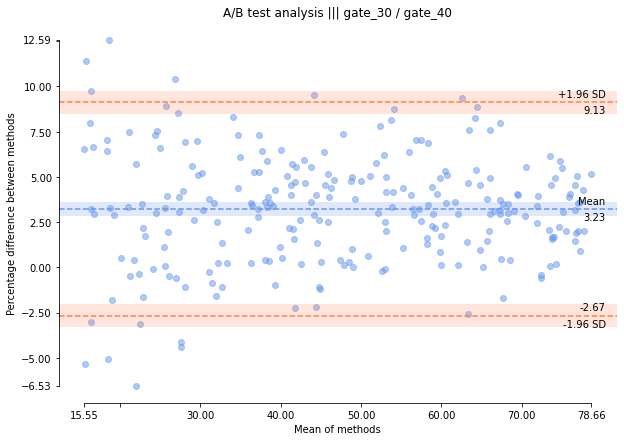

In [ ]:
pc.blandAltman(db['gate_30'], db['gate_40'], percentage=True, 
                      title='A/B test analysis ||| gate_30 / gate_40')

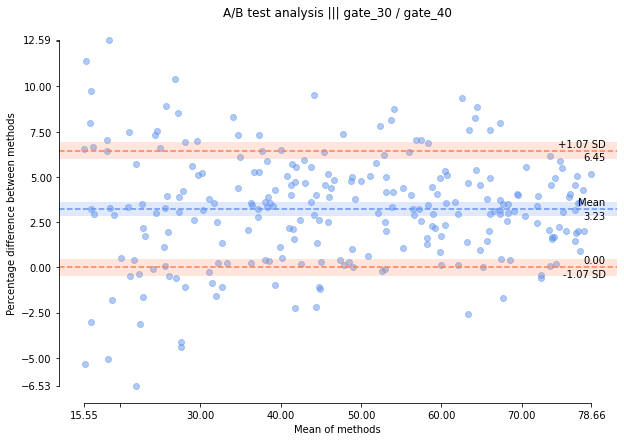

In [ ]:
pc.blandAltman(db['gate_30'], db['gate_40'], percentage=True, 
                      title='A/B test analysis ||| gate_30 / gate_40',
                      limitOfAgreement=1.071)

We see that when limitOfAgreement = 1.07, the boundary is almost equal to 0. Then we have to check in the Normal distribution table the value at 1.07 which is 0.9394, so we are sure at 71.5% that the retention of gate_30 will always be bigger than the one of gate_40 for D7 retention.

In [ ]:
# st.norm.ppf(.95)
# st.norm.cdf(1.6)
(1 - ((1 - st.norm.cdf(1.07))*2))*100

## Results (Frequentist)

AB Testing using Z score for Gate 40 (new) vs Gate 30 (old) has shown that the change is not quite good as per our expectations for D1/D7 retentions. We also measured the performance of D7 retention using Bland Altman plot. The change does not lead to better retentions for both D1 and D7, contrary to what the product managers might think. Unless we can justify the need to implement such a change given the other metrics remain the same, we can safely reject the change or propose for another round of AB tests.

## Bayesian AB Testing

So far we have sufficient evidence to show that the change may not be actually leading to a better retention levels using frequentst methodology. Let's see if the same result is established after the Bayesian approach.

In [ ]:
!pip install arviz==0.6.1 

     |████████████████████████████████| 1.4MB 2.7MB/s 


In [ ]:
import pymc3 as pm
import arviz

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p_treatment]
>Metropolis: [p_control]
100%|██████████| 500500/500500 [02:51<00:00, 2920.88it/s]
The number of effective samples is smaller than 10% for some parameters.


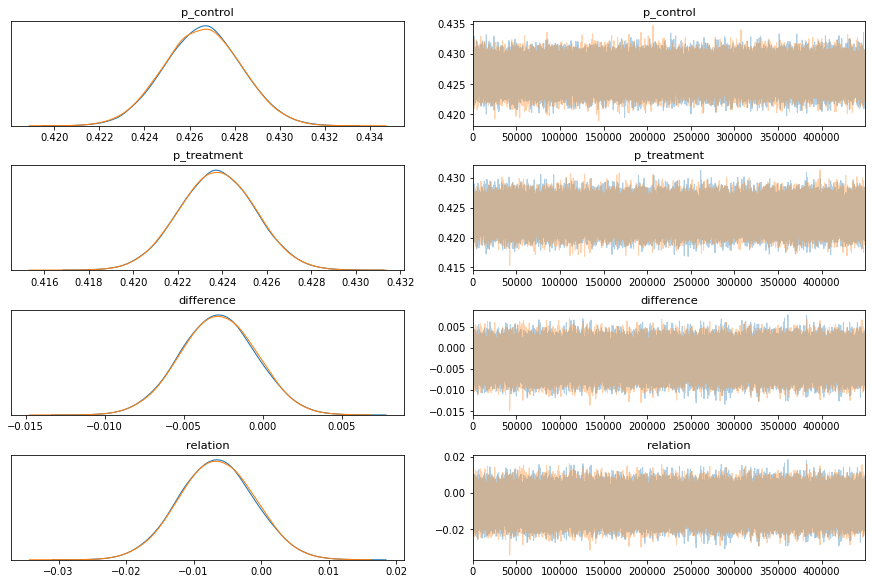

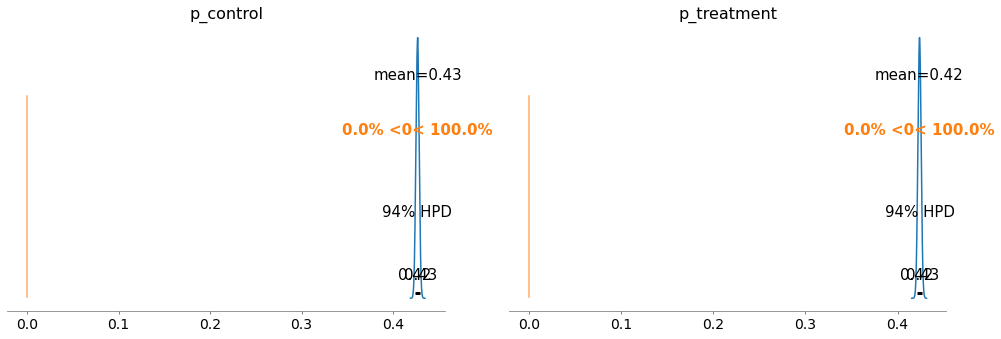

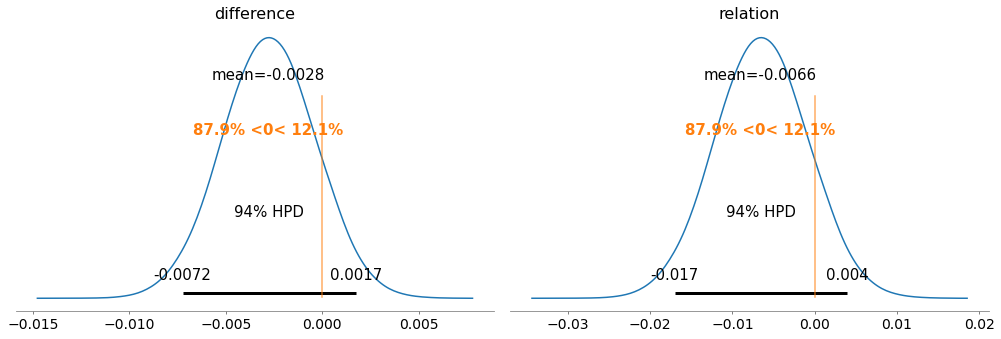

In [ ]:
with pm.Model() as model:

    # define priors
    p_control = pm.Beta('p_control', alpha=conversions_control, beta=total_users_control-conversions_control)
    p_treatment = pm.Beta('p_treatment', alpha=conversions_control, beta=total_users_control-conversions_control)

    obs_control = pm.Binomial('obs_control', n=total_users_control, p=p_control, observed=conversions_control)
    obs_treatment = pm.Binomial('obs_treatment', n=total_users_treatment, p=p_treatment, observed=conversions_treatment)

    pm.Deterministic('difference', p_treatment - p_control)
    pm.Deterministic('relation', (p_treatment/p_control) - 1)

    trace = pm.sample(draws=500000, step=pm.Metropolis(), progressbar=True)

    pm.traceplot(trace[50000:])

    pm.plot_posterior(trace, var_names=['p_control', 'p_treatment'], 
                      ref_val=0)
    pm.plot_posterior(trace, var_names=['difference', 'relation'], 
                      ref_val=0)

The difference plot shows that the chance of treatment group performing poorly as compared to control group is 88% through the Bayesian approach.   


## Conclusion


Both frequentist and Bayesian approaches lead to the same conclusion: making the change of gate from gate 30 to gate 40 will have a high chance of impacting the retention rates. 

1. We need to redesign the experiment to see if the most impactful 
underlying segments are performing better in comparison. For example, we want the users of IOS to not reduce simply because IOS users are generally more profitable in comparison to Android users.

2. Check if the same experiment can be replicated like AABB methodology.

3. Identify the user in-game behaviours that led to the drop in retentions using events. 

4. If the ARPDAU reduced as well, we might not want to proceed further. If the ARPDAU is stable or increases, then there is a chance that the retention drop might not affect the revenue stream.